# Fitting monotonic curves using splines

## Introduction

Today I've decided to write a quick blog post about a feature engineering trick I've learned recently that enables us to fit smooth monotonic curves to data.
This method is particularly useful when modeling relationships that are known to be monotonic, although not necessarily linear.
For this, we will use [$I$-splines](https://projecteuclid.org/journals/statistical-science/volume-3/issue-4/Monotone-Regression-Splines-in-Action/10.1214/ss/1177012761.full) introduced by J. O.
These are monotonically increasing functions that one can construct from regular old $B$-splines.
The two key properties of $I$-splines that we’ll leverage are that they are monotonically increasing and bounded between $0$ and $1$.
So, if we take a linear combination of them with non-negative coefficients, the resulting function will again be monotonically increasing.
Furthermore, a convex combination (a linear combination with non-negative coefficients that sum up to $1$) of $I$-splines results in a function that is also bounded between $0$ and $1$.

In this blog post we will give an implementation of $I$-splines loosely following their [Rccp implementation](https://medium.com/@JiaHsi/monotone-spline-with-rcpp-spline-series-4-4-e30d933f9a3f) (although another implementation is also available in the [dms_variants Python package](https://github.com/jbloomlab/dms_variants)) and then we will see how they perform on data.
We will not discuss splines in general; for an introduction I recommend reading [The Elements of Statistical Learning, Chapter 5](https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf).

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.utils import check_array

np.random.seed(0)
matplotlib.style.use("ggplot")
plt.rcParams["figure.figsize"] = [10, 4]

## Spline plots
Here's an implementation of $I$-splines built on top of $B$-splines with some visualizations of the basis functions.
In addition, we can also see some random linear combinations of these basis functions to give us an idea about what functions can be approximated this way.

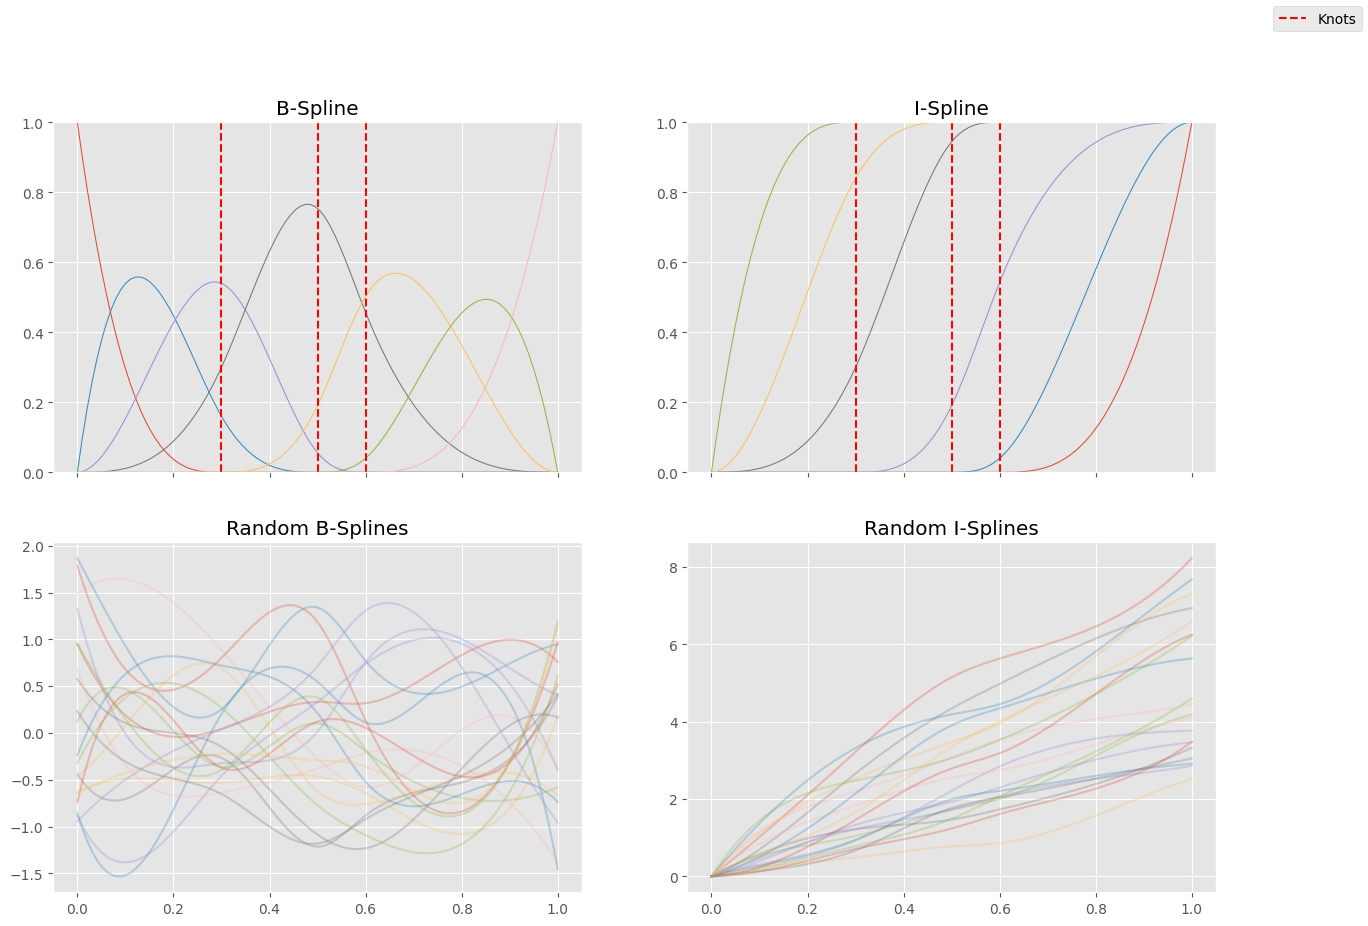

In [35]:
def inter_bspline(p, k, x, y):
    num_rows, num_cols = y.shape
    z = np.zeros((num_rows, num_cols - 1))

    for j in range(num_cols - 1):
        denom_A = k[j + p - 1] - k[j]
        denom_B = k[j + p] - k[j + 1]

        A = (x - k[j]) / denom_A * y[:, j] if denom_A > 0 else 0
        B = (k[j + p] - x) / denom_B * y[:, j + 1] if denom_B > 0 else 0
        z[:, j] = A + B

    return z


def b_spline(p, knots, x):
    N = knots.shape[0]
    num_rows = x.shape[0]
    B = np.zeros((num_rows, N - 1))

    for j in range(N - 1):
        B[:, j] = np.where((x >= knots[j]) & (x < knots[j + 1]), 1, 0)

    for deg in range(1, p):
        B = inter_bspline(deg + 1, knots, x, B)

    return B


def i_spline(
    p,
    knots,
    x,
):
    bsp = b_spline(
        p,
        knots,
        x,
    )
    cumsummed = np.cumsum(
        bsp[:, ::-1],
        axis=1,
    )[:, :-1]

    return np.where(
        (x >= knots[0]) & (x <= knots[-1]),
        cumsummed.T,
        np.where(
            (x < knots[0]),
            0,
            1,
        ),
    ).T


knots = np.array([0.3, 0.5, 0.6])

bsp = b_spline(
    4,
    np.concatenate([np.zeros(4) - 1e-6, knots, np.ones(4) + 1e-6]),
    np.linspace(0, 1, 100),
)

fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

for i in range(bsp.shape[1]):
    ax[0][0].plot(
        np.linspace(0, 1, 100),
        bsp[:, i],
        linewidth=0.75,
    )

isp = i_spline(
    4,
    np.concatenate([np.zeros(4) - 1e-6, knots, np.ones(4) + 1e-6]),
    np.linspace(0, 1, 100),
)

for i in range(isp.shape[1]):
    ax[0][1].plot(
        np.linspace(0, 1, 100),
        isp[:, i],
        linewidth=0.75,
    )

for knot in knots:
    ax[0][0].axvline(
        knot, color="red", linestyle="--", label="Knots" if knot == knots[0] else None
    )
    ax[0][1].axvline(
        knot,
        color="red",
        linestyle="--",
    )

ax[0][0].set_title("B-Spline")
ax[0][1].set_title("I-Spline")

ax[0][0].set_ylim(0, 1)
ax[0][1].set_ylim(0, 1)

for _ in range(20):
    coeffs_isp = np.abs(np.random.normal(size=isp.shape[1]))
    coeffs_bsp = np.random.normal(size=bsp.shape[1])

    ax[1][0].plot(
        np.linspace(0, 1, 100),
        bsp @ coeffs_bsp,
        alpha=0.3,
    )
    ax[1][1].plot(
        np.linspace(0, 1, 100),
        isp @ coeffs_isp,
        alpha=0.3,
    )

ax[1][0].set_title("Random B-Splines")
ax[1][1].set_title("Random I-Splines")

fig.legend()

## Sklearn wrapper

For the sake of simplicity we provide an sklearn wrapper around the `i_spline` function.
Note that this transformer will not work with arrays containing multiple features, but with a little effort, we could extend it to multiple dimensions.
In the two dimensional case, this can be done by constructing the basis functions $f_1, \dots, f_n$, $g_1, \dots, g_m$ for both features separately and then taking
$$h_{i, j}(x, y) = f_i(x) g_j(y) \text{ for each } i=1, \dots, n,\hskip 2pt  j=1, \dots, m.$$
The easiest way to obtain this would be to use the [`PolynomialFeatures`](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) transformer with `interaction_only=True`.
This of course can be generalized to more dimensions.

In [36]:
class ISplineTransformer1D(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):

    def __init__(self, p=4, n_knots=10, decreasing=False, knots=None):
        self.p = p
        self.knots = np.array(knots) if knots is not None else None
        self.n_knots = n_knots
        self.decreasing = decreasing

        self.x_min_ = None
        self.x_max_ = None
        self.knots_ = None

    def fit(self, X, y=None):
        X = check_array(X)
        X = (-1 if self.decreasing else 1) * X
        self.x_min_ = np.min(X) - 1e-6
        self.x_max_ = np.max(X) + 1e-6

        if self.knots is None:
            extended_knots = np.linspace(self.x_min_, self.x_max_, self.n_knots)
        else:
            extended_knots = self.knots

        self.knots_ = np.concatenate(
            [
                np.zeros(self.p) + self.x_min_,
                extended_knots,
                np.zeros(self.p) + self.x_max_,
            ],
        )

        return self

    def transform(self, X):
        return i_spline(
            self.p,
            self.knots_,
            (-1 if self.decreasing else 1) * X[:, 0],
        )

## Data Generation

In this post, we will work with synthetic data generated by
$$y_i = X_i^2 + 0.1 \sin(20 X_i) + 1 + \varepsilon_i,$$
where $\varepsilon_i \sim \operatorname{N}(0, 0.1)$ are independent.

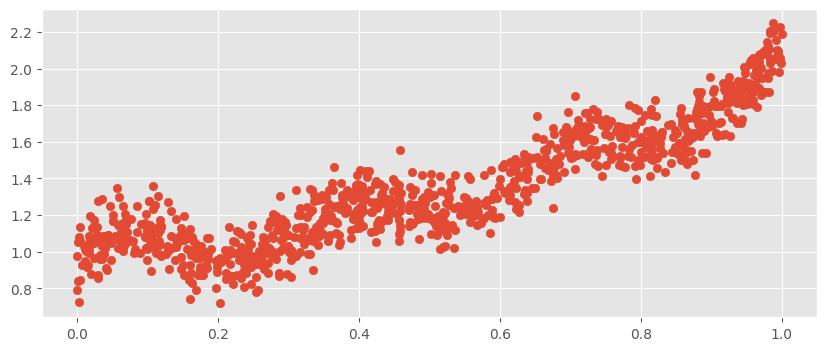

In [37]:
N = 1000

X = np.random.uniform(0, 1, size=N)
y =  X ** 2 + .1 * np.sin(20 * X) + 1 + .1 * np.random.randn(N)

plt.scatter(X, y)

## Fit Scikit-Learn pipeline
We will use Scikit Learn's `LinearRegression` with the setting `positive=True` to enforce monotonicity.
When we compare the predictions to those of sklearn's [`IsotonicRegression`](https://scikit-learn.org/1.5/modules/isotonic.html), we find a very similar fit, however it is way smoother.

We note, however, that in both cases outside of the training distribution we get constant predictions.

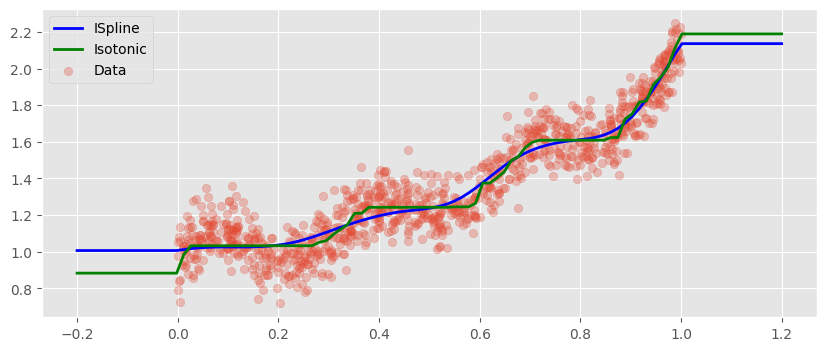

In [42]:
pipe = make_pipeline(
    ISplineTransformer1D(n_knots=10),
    LinearRegression(positive=True),
)
pipe.fit(X[:, None], y)

iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(X, y)

X_test = np.linspace(-0.2, 1.2, 100)[:, None]

plt.plot(X_test[:, 0], pipe.predict(X_test), color="blue", linewidth=2, label="ISpline")
plt.plot(
    X_test[:, 0], iso.predict(X_test), color="green", linewidth=2, label="Isotonic"
)

plt.scatter(X, y, alpha=0.3, label="Data")

plt.legend()